In [1]:
from tools import mvsr_predictor, tall_vector, loo_score, total_score, bigModel
import xarray as xr
from sklearn.preprocessing import StandardScaler, PowerTransformer, QuantileTransformer, MinMaxScaler
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import joblib
import re
from matplotlib.offsetbox import (TextArea, DrawingArea, OffsetImage,
                                  AnnotationBbox)
import matplotlib.dates as mdates

In [2]:
# load the model
full_model = joblib.load('model.bm')

/Users/julianquick/miniconda3/envs/test/lib/python3.10/site-packages/sklearn/base.py:299: UserWarning: Trying to unpickle estimator MinMaxScaler from version 1.1.2 when using version 1.2.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/Users/julianquick/miniconda3/envs/test/lib/python3.10/site-packages/sklearn/base.py:299: UserWarning: Trying to unpickle estimator QuantileTransformer from version 1.1.2 when using version 1.2.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


First, we just evaluate one sample

In [3]:
# Create sample to evaluate
one_sample = pd.DataFrame({'onshore_wind_cost': [0.9],
                           'offshore_wind_cost': [0.8],
                           'solarpv_cost': [1.1],
                           'natural_gas_price': [1.2],
                           'CO2_bonds_price': [1.02],
                           'heatpump_cost': [0.9],
                           'electrolyser_cost': [1.1]
                          })
one_sample

,onshore_wind_cost,offshore_wind_cost,solarpv_cost,natural_gas_price,CO2_bonds_price,heatpump_cost,electrolyser_cost
0,0.9,0.8,1.1,1.2,1.02,0.9,1.1


In [4]:
# evaluate the sample
ds_oneSample = full_model.predict(one_sample)

In [5]:
# view the sample output
ds_oneSample

<xarray.Dataset>
Dimensions:                        (year: 3, weathertime: 8736, region: 24,
                                    realization_of_inputs: 1, cross_region: 24)
Coordinates:
  * year                           (year) int64 2025 2035 2045
  * weathertime                    (weathertime) datetime64[ns] 2012-01-02 .....
  * region                         (region) object 'BE' 'DE4-E' ... 'SE4' 'UK'
  * realization_of_inputs          (realization_of_inputs) int64 0
  * cross_region                   (cross_region) object 'BE' 'DE4-E' ... 'UK'
Data variables: (12/16)
    Price_electricity              (year, weathertime, region, realization_of_inputs) float64 ...
    VRE_Capacities_Wind_Onshore    (year, region, realization_of_inputs) float64 ...
    VRE_Capacities_Wind_Offshore   (year, region, realization_of_inputs) float64 ...
    VRE_Capacities_Solar_PV        (year, region, realization_of_inputs) float64 ...
    Transmission_Lines_Capacities  (year, region, realization_of_inputs, cross_region) float64 ...
    Electricity_demand_EV          (year, weathertime, region, realization_of_inputs) float64 ...
    ...                             ...
    offshore_wind_cost             (realization_of_inputs) float64 0.8
    solarpv_cost                   (realization_of_inputs) float64 1.1
    natural_gas_price              (realization_of_inputs) float64 1.2
    CO2_bonds_price                (realization_of_inputs) float64 1.02
    heatpump_cost                  (realization_of_inputs) float64 0.9
    electrolyser_cost              (realization_of_inputs) float64 1.1

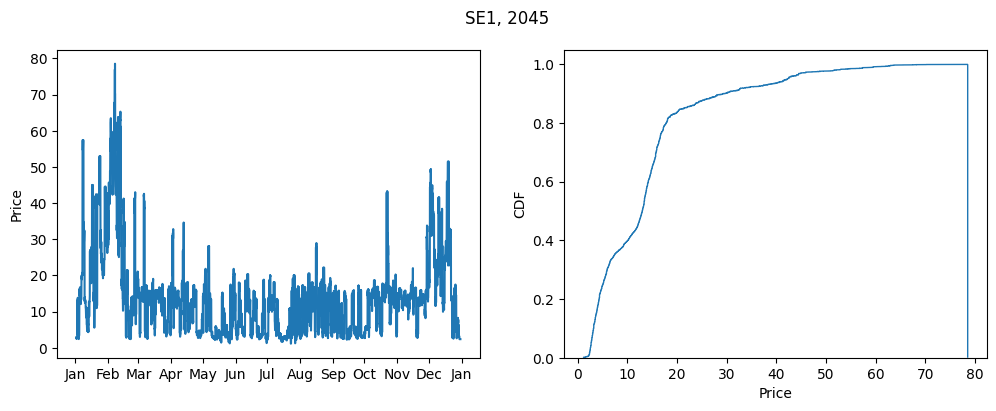

In [6]:
# plot the sample output
region = 'SE1'
year = 2045
prices = ds_oneSample.Price_electricity.sel(year=year, region=region).values
fig, ax = plt.subplots(1, 2, figsize=(12, 4))
ax[1].hist(prices, 1000, density=True, cumulative=True,  histtype=u'step')
plt.suptitle(f'{region}, {year}')
ax[1].set_xlabel('Price')
ax[1].set_ylabel('CDF')
ax[0].plot(ds_oneSample.weathertime, prices)
ax[0].set_ylabel('Price')
# Set the locator
locator = mdates.MonthLocator()  # every month
# Specify the format - %b gives us Jan, Feb...
fmt = mdates.DateFormatter('%b')
ax[0].xaxis.set_major_locator(locator)
ax[0].xaxis.set_major_formatter(fmt)


Next, we evaluate two samples. These samples represent the cost of wind being low or high.

In [7]:
# Create sample to evaluate
two_samples = pd.DataFrame({'onshore_wind_cost': [0.8, 1.2],
                           'offshore_wind_cost': [0.7, 1.3],
                           'solarpv_cost': [1.0, 1.0],
                           'natural_gas_price': [1.0, 1.0],
                           'CO2_bonds_price': [1.0, 1.0],
                           'heatpump_cost': [1.0, 1.0],
                           'electrolyser_cost': [1.0, 1.0]
                          })
two_samples

,onshore_wind_cost,offshore_wind_cost,solarpv_cost,natural_gas_price,CO2_bonds_price,heatpump_cost,electrolyser_cost
0,0.8,0.7,1.0,1.0,1.0,1.0,1.0
1,1.2,1.3,1.0,1.0,1.0,1.0,1.0


In [8]:
# evaluate the sample
ds_twoSamples = full_model.predict(two_samples, output=['Price_electricity'])

In [9]:
ds_twoSamples

<xarray.Dataset>
Dimensions:                (year: 3, weathertime: 8736, region: 24,
                            realization_of_inputs: 2, cross_region: 24)
Coordinates:
  * year                   (year) int64 2025 2035 2045
  * weathertime            (weathertime) datetime64[ns] 2012-01-02 ... 2012-1...
  * region                 (region) object 'BE' 'DE4-E' 'DE4-N' ... 'SE4' 'UK'
  * realization_of_inputs  (realization_of_inputs) int64 0 1
  * cross_region           (cross_region) object 'BE' 'DE4-E' ... 'SE4' 'UK'
Data variables:
    Price_electricity      (year, weathertime, region, realization_of_inputs) float64 ...
    onshore_wind_cost      (realization_of_inputs) float64 0.8 1.2
    offshore_wind_cost     (realization_of_inputs) float64 0.7 1.3
    solarpv_cost           (realization_of_inputs) float64 1.0 1.0
    natural_gas_price      (realization_of_inputs) float64 1.0 1.0
    CO2_bonds_price        (realization_of_inputs) float64 1.0 1.0
    heatpump_cost          (realization_of_inputs) float64 1.0 1.0
    electrolyser_cost      (realization_of_inputs) float64 1.0 1.0

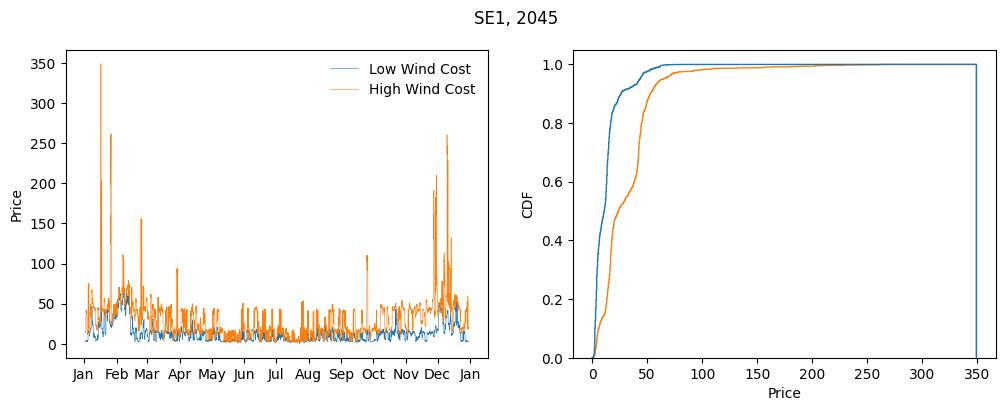

In [10]:
# plot the low/high wind output
region = 'SE1'
year = 2045
prices = ds_twoSamples.Price_electricity.sel(year=year, region=region).values
fig, ax = plt.subplots(1, 2, figsize=(12, 4))
ax[1].hist(prices, 1000, density=True, cumulative=True,  histtype=u'step')
plt.suptitle(f'{region}, {year}')
ax[1].set_xlabel('Price')
ax[1].set_ylabel('CDF')
ax[0].plot(ds_oneSample.weathertime, prices, label=['Low Wind Cost', 'High Wind Cost'], lw=0.4)
ax[0].legend(loc='upper right')
ax[0].set_ylabel('Price')
# Set the locator
locator = mdates.MonthLocator()  # every month
# Specify the format - %b gives us Jan, Feb...
fmt = mdates.DateFormatter('%b')
ax[0].xaxis.set_major_locator(locator)
ax[0].xaxis.set_major_formatter(fmt)

Finally, we sample the inputs a few times to get a feel for the range of possible outcomes

In [11]:
import chaospy 
dists = [chaospy.Uniform(.8, 1.2), # onshore wind
         chaospy.Uniform(.7, 1.3), # offshore wind
         chaospy.Uniform(.8, 1.2), # solarpv_cost 
         chaospy.Uniform(1, 10), # natural_gas_price
         chaospy.Uniform(.8, 1.2), # CO2_bonds_price
         chaospy.Uniform(.8, 1.2), # heatpump_cost
         chaospy.Uniform(.8, 1.2) # electrolyser_cost
        ]
joint = chaospy.J(*dists)
samples = joint.sample(30)
many_samples = two_samples = pd.DataFrame({'onshore_wind_cost': samples[0],
                           'offshore_wind_cost': samples[1],
                           'solarpv_cost': samples[2],
                           'natural_gas_price': samples[3],
                           'CO2_bonds_price': samples[4],
                           'heatpump_cost': samples[5],
                           'electrolyser_cost': samples[6]
                          })

In [12]:
ds = full_model.predict(many_samples)

In [13]:
ds

<xarray.Dataset>
Dimensions:                        (year: 3, weathertime: 8736, region: 24,
                                    realization_of_inputs: 30, cross_region: 24)
Coordinates:
  * year                           (year) int64 2025 2035 2045
  * weathertime                    (weathertime) datetime64[ns] 2012-01-02 .....
  * region                         (region) object 'BE' 'DE4-E' ... 'SE4' 'UK'
  * realization_of_inputs          (realization_of_inputs) int64 0 1 2 ... 28 29
  * cross_region                   (cross_region) object 'BE' 'DE4-E' ... 'UK'
Data variables: (12/16)
    Price_electricity              (year, weathertime, region, realization_of_inputs) float64 ...
    VRE_Capacities_Wind_Onshore    (year, region, realization_of_inputs) float64 ...
    VRE_Capacities_Wind_Offshore   (year, region, realization_of_inputs) float64 ...
    VRE_Capacities_Solar_PV        (year, region, realization_of_inputs) float64 ...
    Transmission_Lines_Capacities  (year, region, realization_of_inputs, cross_region) float64 ...
    Electricity_demand_EV          (year, weathertime, region, realization_of_inputs) float64 ...
    ...                             ...
    offshore_wind_cost             (realization_of_inputs) float64 0.8025 ......
    solarpv_cost                   (realization_of_inputs) float64 1.051 ... ...
    natural_gas_price              (realization_of_inputs) float64 4.862 ... ...
    CO2_bonds_price                (realization_of_inputs) float64 0.9513 ......
    heatpump_cost                  (realization_of_inputs) float64 0.8755 ......
    electrolyser_cost              (realization_of_inputs) float64 1.183 ... ...

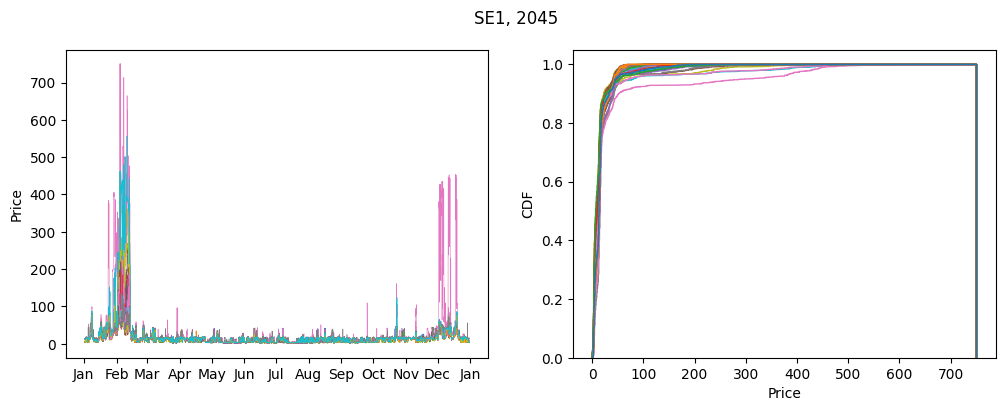

In [14]:
# plot the output
region = 'SE1'
year = 2045
prices = ds.Price_electricity.sel(year=year, region=region).values
fig, ax = plt.subplots(1, 2, figsize=(12, 4))
ax[1].hist(prices, 1000, density=True, cumulative=True,  histtype=u'step')
plt.suptitle(f'{region}, {year}')
ax[1].set_xlabel('Price')
ax[1].set_ylabel('CDF')
ax[0].plot(ds.weathertime, prices, lw=0.4)
ax[0].set_ylabel('Price')
# Set the locator
locator = mdates.MonthLocator()  # every month
# Specify the format - %b gives us Jan, Feb...
fmt = mdates.DateFormatter('%b')
ax[0].xaxis.set_major_locator(locator)
ax[0].xaxis.set_major_formatter(fmt)

/Users/julianquick/miniconda3/envs/test/lib/python3.10/site-packages/matplotlib/cm.py:478: RuntimeWarning: invalid value encountered in cast
  xx = (xx * 255).astype(np.uint8)


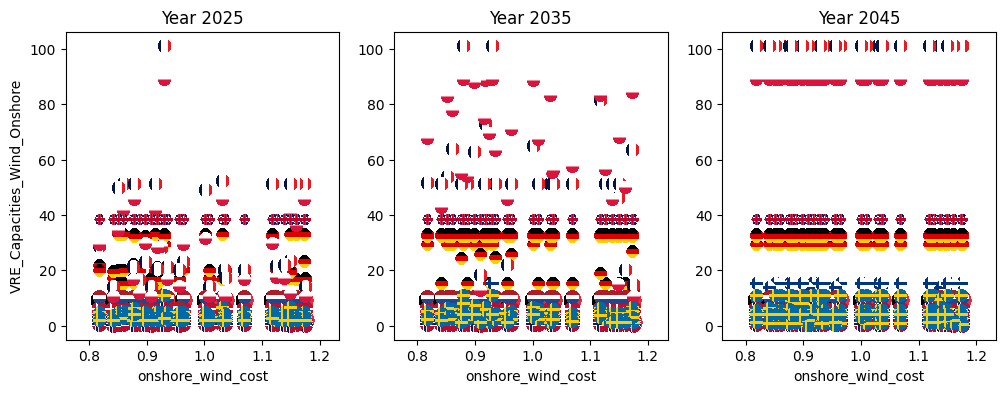

In [15]:
x_nam = 'onshore_wind_cost'
y_nam = 'VRE_Capacities_Wind_Onshore'

#plt.style.use('dark_background')
fig, ax = plt.subplots(1, 3, figsize=(12, 4))
maxX = -20
minX = 20
maxY = -20
minY = 20

for region in ds.region.values:
    for yy, year in enumerate(ds.year.values):
        nam = re.sub('\d+', '', region.lower()).split('-')[0]
        if region == 'UK': nam = 'gb'
        if region == 'FIN': nam = 'fi'
        img = plt.imread(f"plotting/country-flags/png250px/{nam}.png")

        cx = img.shape[0] // 2
        cy = img.shape[1] // 2
        aa, jj, ll = np.indices(img.shape)
        mask = (aa - cx) ** 2 + (jj - cy) ** 2 > np.minimum(cx ** 2, cy ** 2)
        img[mask] = None
        xdat = ds.sel(year=year, region=region)[x_nam]
        ydat = ds.sel(year=year, region=region)[y_nam]
        if xdat.max() > maxX: maxX = xdat.max()
        if xdat.min() < minX: minX = xdat.min()
        if ydat.max() > maxY: maxY = ydat.max()
        if ydat.min() < minY: minY = ydat.min()
        
        #plt.scatter(xdat, ydat)
        for ii in range(xdat.size):
            imagebox = OffsetImage(img, zoom=0.06)
            imagebox.image.axes = ax[yy]
            ab = AnnotationBbox(imagebox, (xdat[ii], ydat[ii]), frameon=False)

            ax[yy].add_artist(ab)


PAD = .05
ax[0].set_ylabel(y_nam)
for ii in range(3):
    ax[ii].set_title(f'Year {ds.year.values[ii]}')
    ax[ii].set_xlabel(x_nam)
    ax[ii].set_ylim(minY - maxY * PAD, maxY * (1 + PAD))
    ax[ii].set_xlim(minX - maxX * PAD, maxX * (1 + PAD))

/Users/julianquick/miniconda3/envs/test/lib/python3.10/site-packages/matplotlib/cm.py:478: RuntimeWarning: invalid value encountered in cast
  xx = (xx * 255).astype(np.uint8)


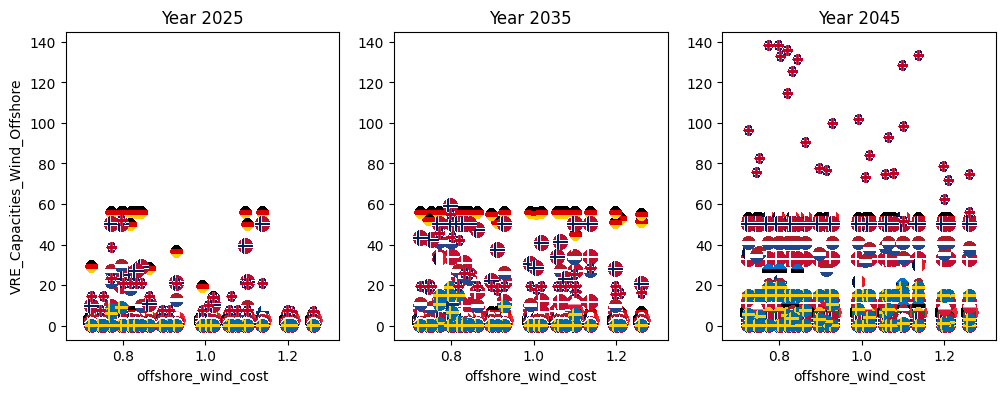

In [16]:
x_nam = 'offshore_wind_cost'
y_nam = 'VRE_Capacities_Wind_Offshore'

#plt.style.use('dark_background')
fig, ax = plt.subplots(1, 3, figsize=(12, 4))
maxX = -20
minX = 20
maxY = -20
minY = 20

for region in ds.region.values:
    for yy, year in enumerate(ds.year.values):
        nam = re.sub('\d+', '', region.lower()).split('-')[0]
        if region == 'UK': nam = 'gb'
        if region == 'FIN': nam = 'fi'
        img = plt.imread(f"plotting/country-flags/png250px/{nam}.png")

        cx = img.shape[0] // 2
        cy = img.shape[1] // 2
        aa, jj, ll = np.indices(img.shape)
        mask = (aa - cx) ** 2 + (jj - cy) ** 2 > np.minimum(cx ** 2, cy ** 2)
        img[mask] = None
        xdat = ds.sel(year=year, region=region)[x_nam]
        ydat = ds.sel(year=year, region=region)[y_nam]
        if xdat.max() > maxX: maxX = xdat.max()
        if xdat.min() < minX: minX = xdat.min()
        if ydat.max() > maxY: maxY = ydat.max()
        if ydat.min() < minY: minY = ydat.min()
        
        #plt.scatter(xdat, ydat)
        for ii in range(xdat.size):
            imagebox = OffsetImage(img, zoom=0.06)
            imagebox.image.axes = ax[yy]
            ab = AnnotationBbox(imagebox, (xdat[ii], ydat[ii]), frameon=False)

            ax[yy].add_artist(ab)


PAD = .05
ax[0].set_ylabel(y_nam)
for ii in range(3):
    ax[ii].set_title(f'Year {ds.year.values[ii]}')
    ax[ii].set_xlabel(x_nam)
    ax[ii].set_ylim(minY - maxY * PAD, maxY * (1 + PAD))
    ax[ii].set_xlim(minX - maxX * PAD, maxX * (1 + PAD))

/var/folders/5p/nfz1p4ls3q91_7x9ktyf9c7r0000gn/T/ipykernel_50954/4217550053.py:45: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  ax[ii].set_ylim(minY - maxY * PAD, maxY * (1 + PAD))
/var/folders/5p/nfz1p4ls3q91_7x9ktyf9c7r0000gn/T/ipykernel_50954/4217550053.py:45: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  ax[ii].set_ylim(minY - maxY * PAD, maxY * (1 + PAD))
/var/folders/5p/nfz1p4ls3q91_7x9ktyf9c7r0000gn/T/ipykernel_50954/4217550053.py:45: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  ax[ii].set_ylim(minY - maxY * PAD, maxY * (1 + PAD))
/Users/julianquick/miniconda3/envs/test/lib/python3.10/site-packages/matplotlib/cm.py:478: RuntimeWarning: invalid value encountered in cast
  xx = (xx * 255).astype(np.uint8)


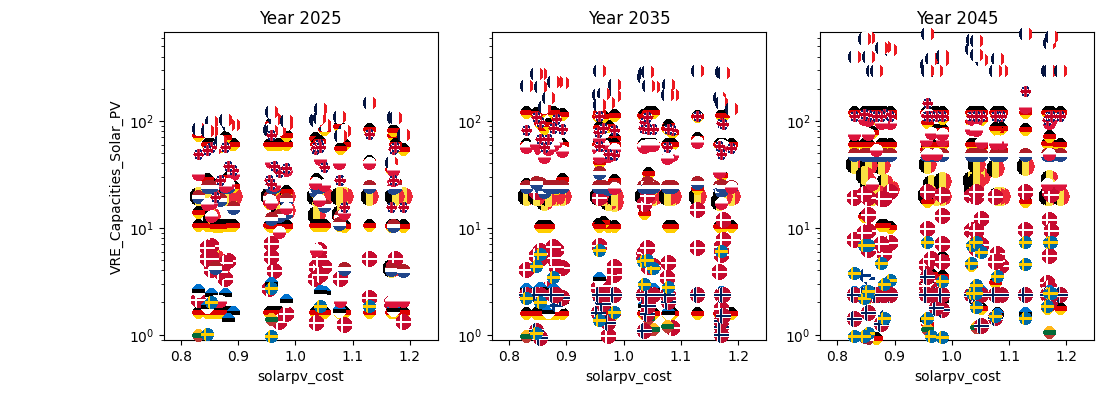

In [17]:
x_nam = 'solarpv_cost'
y_nam = 'VRE_Capacities_Solar_PV'

#plt.style.use('dark_background')
fig, ax = plt.subplots(1, 3, figsize=(12, 4))
maxX = -20
minX = 20
maxY = -20
minY = 20

for region in ds.region.values:
    for yy, year in enumerate(ds.year.values):
        nam = re.sub('\d+', '', region.lower()).split('-')[0]
        if region == 'UK': nam = 'gb'
        if region == 'FIN': nam = 'fi'
        img = plt.imread(f"plotting/country-flags/png250px/{nam}.png")

        cx = img.shape[0] // 2
        cy = img.shape[1] // 2
        aa, jj, ll = np.indices(img.shape)
        mask = (aa - cx) ** 2 + (jj - cy) ** 2 > np.minimum(cx ** 2, cy ** 2)
        img[mask] = None
        xdat = ds.sel(year=year, region=region)[x_nam]
        ydat = ds.sel(year=year, region=region)[y_nam]
        if xdat.max() > maxX: maxX = xdat.max()
        if xdat.min() < minX: minX = xdat.min()
        if ydat.max() > maxY: maxY = ydat.max()
        if ydat.min() < minY: minY = ydat.min()
        
        #plt.scatter(xdat, ydat)
        for ii in range(xdat.size):
            imagebox = OffsetImage(img, zoom=0.06)
            imagebox.image.axes = ax[yy]
            ab = AnnotationBbox(imagebox, (xdat[ii], ydat[ii]), frameon=False)

            ax[yy].add_artist(ab)


PAD = .05
ax[0].set_ylabel(y_nam)
for ii in range(3):
    ax[ii].set_title(f'Year {ds.year.values[ii]}')
    ax[ii].set_xlabel(x_nam)
    ax[ii].set_yscale('log')
    ax[ii].set_ylim(minY - maxY * PAD, maxY * (1 + PAD))
    ax[ii].set_xlim(minX - maxX * PAD, maxX * (1 + PAD))